# Grundwasser Extremereignis Vorhersage mit RF und min. Anzahl an Features

In [1]:
from tools.InstanceAssembler import point_data_assembler
from tools.FeatureHandlers import RegnieHandler, DWDAirTempHandler, UTMEastingHandler, UTMNorthingHandler, XtremeBoundHandler, GwLvlChangeHandler
from tools.TargetHandlers import XtremeClassificationHandler
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from datetime import date, timedelta
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import shap

## Instanzen zusammestellen
Betrachtet werden 329 als nicht anthropogen beeinflusste Stationen in Hessen für den Zielwert-Zeitraum von Feb. 2009 bis Dez. 2017 gewonnen.

Zielwert ist eine Klassifikation der Grundwasserstandsänderung innerhalb 4 Wochen in extrem fallend (5. Perzentil), exstrem steigend (95. Perzentil) und normale Änderung.

Der Eingabezeitraum beträgt 1 Woche mit einer zeitlichen Auflösung von 1 Woche.

**Features:**
- Niederschlags- und Temperaturdaten als Rasterdurchschnitt, Einflussgröße 11x11 km
- Grundwasserstandsänderung zu jeweil 4 Wochen davor

In [2]:
stations = pd.read_csv(r'G:/GruV-Net/data/anthropogen-unbeeinflusste-Messstellen/HE_complete.csv', header=0).ProjID.tolist()
dates = pd.date_range(date(2009,2,2), date(2017,12,25), freq='W-MON').date

In [3]:
data = pd.read_csv(r'G:/GruV-Net/data/assembled_instances/GruVXtreme/2009-02-02_2017-12-25_all-stations_52w_offset4_Regnie-AirTemp-UTMCoord-Bounds_GwLvl_raster11_mean.csv', index_col=0)
data

,Date,Station,XtremeClass,UTMEasting,UTMNorthing,XtremeBound0.05,XtremeBound0.95,XtremeBound0.5,Regnie0,DWDAirTemp0,...,GwLvlChange48,Regnie49,DWDAirTemp49,GwLvlChange49,Regnie50,DWDAirTemp50,GwLvlChange50,Regnie51,DWDAirTemp51,GwLvlChange51
0,2009-02-02,HE_9523,0.0,504533,5566642,-0.7205,0.74725,0.00,14.355373,44.165291,...,0.130000,1.200809,13.495868,NaN,5.498591,13.495868,NaN,0.866850,-21.256199,0.74
1,2009-02-02,HE_10223,0.0,510151,5554577,-0.3105,0.30400,0.00,15.696871,43.115704,...,0.140000,0.633035,12.462810,NaN,4.072534,12.462810,NaN,0.380160,-24.991735,0.18
2,2009-02-02,HE_8872,0.0,506353,5573350,-0.5480,0.58800,0.00,13.949748,41.950413,...,0.340000,1.075200,11.347108,NaN,6.588911,11.347108,NaN,1.051381,-22.743801,0.50
3,2009-02-02,HE_10225,-1.0,508082,5555747,-0.7515,0.63075,0.00,15.176651,44.322315,...,-0.200000,0.629307,13.636364,NaN,4.068375,13.636364,NaN,0.392859,-23.595041,1.16
4,2009-02-02,HE_9482,0.0,494727,5568712,-0.7300,0.68000,0.00,10.022560,45.388432,...,0.140000,0.282760,15.702479,NaN,4.372041,15.702479,NaN,1.306451,-21.413223,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152980,2017-12-25,HE_8999,NaN,543298,5580956,-2.0900,2.14000,0.02,1.721236,4.975206,...,-0.640000,9.107618,42.140495,NaN,44.138382,42.140495,NaN,28.762079,42.140495,NaN
152981,2017-12-25,HE_8957,NaN,529923,5580147,-2.4210,2.64525,-0.08,1.801329,8.239670,...,1.200000,10.050959,44.380165,1.34,50.371204,44.380165,1.89,37.851845,44.380165,NaN
152982,2017-12-25,HE_6362,NaN,518368,5644331,-0.1200,0.11550,0.00,2.650348,15.347108,...,NaN,4.236617,49.801651,NaN,24.925440,49.801651,NaN,20.799204,49.801651,NaN
152983,2017-12-25,HE_15651,NaN,474196,5584236,-1.2740,1.30000,-0.02,0.997533,17.504131,...,0.366667,5.387736,51.545456,-0.03,14.977531,51.545456,0.09,24.800459,51.545456,NaN


In [4]:
#Samples ohne Zielklasse werden entfernt
drop = data.dropna(subset=['XtremeClass'])
drop = drop.fillna(0)

In [5]:
X = drop.iloc[:,161:]
y = drop.iloc[:,2]

In [10]:
X

,Regnie51,DWDAirTemp51,GwLvlChange51
0,0.866850,-21.256199,0.74
1,0.380160,-24.991735,0.18
2,1.051381,-22.743801,0.50
3,0.392859,-23.595041,1.16
4,1.306451,-21.413223,0.72
...,...,...,...
152643,17.584320,48.380165,0.40
152650,24.925440,49.801651,0.17
152652,50.371204,44.380165,1.89
152654,14.977531,51.545456,0.09


In [6]:
preds = []
trues = []
model = RandomForestClassifier()
for train_idx, test_idx in TimeSeriesSplit(5).split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    preds.append(pred)
    trues.append(y_test)

for i in range(len(preds)):
    print('Split ', i+1, ' - Accuracy: ',metrics.accuracy_score(preds[i],trues[i]))
    print('---')

Split  1  - Accuracy:  0.8483729910841047
---
Split  2  - Accuracy:  0.9115793060366858
---
Split  3  - Accuracy:  0.8932364131977966
---
Split  4  - Accuracy:  0.8182179567266739
---
Split  5  - Accuracy:  0.9282185246180931
---


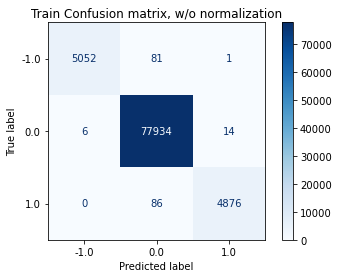

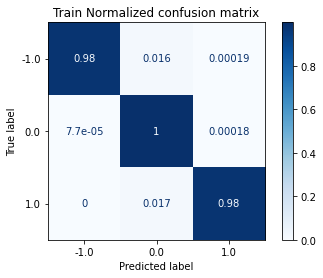

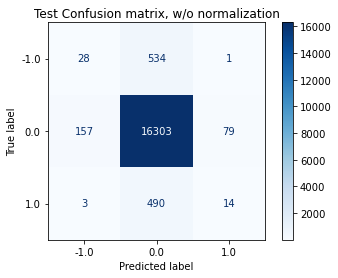

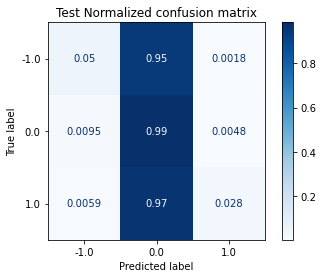

In [7]:
titles_options = [("Train Confusion matrix, w/o normalization", X_train, y_train, None),
                  ("Train Normalized confusion matrix", X_train, y_train, 'true'),
                  ("Test Confusion matrix, w/o normalization", X_test, y_test, None),
                  ("Test Normalized confusion matrix", X_test, y_test, 'true')]
for title, feat, target, normalize in titles_options:
    disp = metrics.plot_confusion_matrix(model, feat, target,
                                 display_labels=model.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

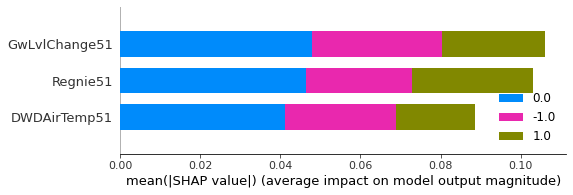

In [48]:
explainer = shap.TreeExplainer(model)
shap_values_train = explainer.shap_values(X_train.iloc[:1000,:])
shap.summary_plot(shap_values_train, X_train, class_names=model.classes_, plot_type="bar")

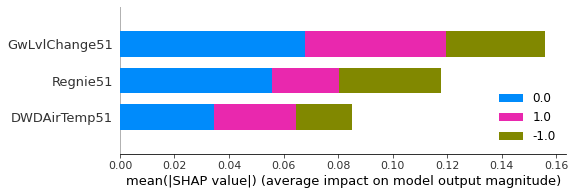

In [49]:
shap_values_test = explainer.shap_values(X_test.iloc[:1000,:])
shap.summary_plot(shap_values_test, X_test, class_names=model.classes_, plot_type="bar")

In [41]:
#A -> Actual, P -> Predicted

APlus_PPlus = [x for x in np.where(preds[4]==1)[0] if x in np.where(trues[4]==1)[0]]
APlus_PNorm = [x for x in np.where(preds[4]==0)[0] if x in np.where(trues[4]==1)[0]]
APlus_PNeg = [x for x in np.where(preds[4]==-1)[0] if x in np.where(trues[4]==1)[0]]

ANorm_PPlus = [x for x in np.where(preds[4]==1)[0] if x in np.where(trues[4]==0)[0]]
ANorm_PNorm = [x for x in np.where(preds[4]==0)[0] if x in np.where(trues[4]==0)[0]]
ANorm_PNeg = [x for x in np.where(preds[4]==-1)[0] if x in np.where(trues[4]==0)[0]]

ANeg_PPlus = [x for x in np.where(preds[4]==1)[0] if x in np.where(trues[4]==-1)[0]]
ANeg_PNorm = [x for x in np.where(preds[4]==0)[0] if x in np.where(trues[4]==-1)[0]]
ANeg_PNeg = [x for x in np.where(preds[4]==-1)[0] if x in np.where(trues[4]==-1)[0]]

### Predicted +1, Actual +1
Class 0: Negative Extreme Event

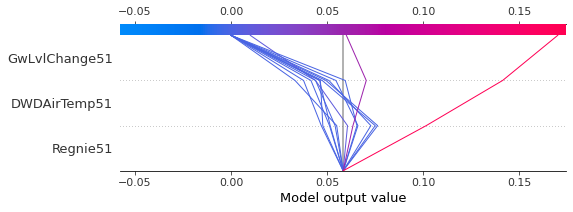

In [131]:
shap.initjs()
shap.decision_plot(explainer.expected_value[0], np.array([shap_values_test[0][i] for i in APlus_PPlus]), X_test.iloc[APlus_PPlus])

In [126]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], np.array([shap_values_test[0][i] for i in APlus_PPlus]), X_test.iloc[APlus_PPlus])

Class 1: Normal Event

In [127]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], np.array([shap_values_test[1][i] for i in APlus_PPlus]), X_test.iloc[APlus_PPlus])

Class 2: Positive Extreme Event

In [128]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], np.array([shap_values_test[2][i] for i in APlus_PPlus]), X_test.iloc[APlus_PPlus])

### Predicted 0, Actual +1
Class 0: Negative Extreme Event

In [123]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], np.array([shap_values_test[0][i] for i in APlus_PNorm[:100]]), X_test.iloc[APlus_PNorm[:100]])

Class 1: Normal Event

In [124]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], np.array([shap_values_test[1][i] for i in APlus_PNorm[:100]]), X_test.iloc[APlus_PNorm[:100]])

Class 2: Positive Extreme Event

In [125]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], np.array([shap_values_test[2][i] for i in APlus_PNorm[:100]]), X_test.iloc[APlus_PNorm[:100]])

---

In [94]:
#Predicted +1
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values_test[2][19], X_test.iloc[19])